## Preparação e Limpeza de Dados

In [3]:
# Importação das Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Treinamento Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# Balanceamento de dados
from imblearn.over_sampling import SMOTE

# Otimização de hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV

# Avaliação e Análise 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [4]:
# Carregamento e leitura das bibliotecas
df = pd.read_csv("docs/treino.csv")

df.head()


,op_padronizado,dt_ocorrencia,hr_ocorrencia,uf,regiao,latitude,longitude,cat_aeronave,fase_operacao,modelo_aeronave,peso_max_decolagem,numero_assentos,nome_fabricante,les_fatais_trip
0,AEROAGRICOLA CHAPADAO LTDA,21/12/1999,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-235,1315.0,1.0,PIPER AIRCRAFT,0
1,RONDON AVIACAO AGRICOLA LTDA,06/01/2000,NaN,MT,Centro-Oeste,NaN,NaN,S05,NaN,EMB-201,1800.0,1.0,NEIVA,0
2,SAPA SERV. AEREO DE PROTECAO AGRICOLA,22/02/2000,NaN,RS,Sul,NaN,NaN,S05,NaN,A188B,1497.0,1.0,CESSNA AIRCRAFT,0
3,AERO AGRICOLA CAICARA LTDA,10/05/2000,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-260,1315.0,1.0,PIPER AIRCRAFT,0
4,AVIACAO AGRICOLA RECREIO LTDA,09/11/2000,NaN,Indeterminado,NaN,NaN,NaN,TPP,NaN,369HS,1157.0,5.0,HUGHES HELICOPTER,0


 Tratamento de dados

In [5]:
# Pegar informações da Tabela
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


In [6]:
# Remoção de duplicatas

print("--- Informações Iniciais do DataFrame ---")
df.info()

# Verifica e remove linhas duplicadas
linhas_antes = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print(f"Linhas antes da remoção de duplicatas: {linhas_antes}")
print(f"Linhas após a remoção de duplicatas: {len(df)}")

--- Informações Iniciais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB
Linha

In [7]:
# Converte latitude e longitude para números, trocando a vírgula por ponto
print("Convertendo 'latitude' e 'longitude' para Float")
df['latitude'] = df['latitude'].astype(str).str.replace(',', '.').astype(float)
df['longitude'] = df['longitude'].astype(str).str.replace(',', '.').astype(float)

# Converte a coluna de data para o formato datetime
# O interpretado não consegue entender o formato Object para data e hora
print("Convertendo 'dt_ocorrencia' para formato de data...")
df['dt_ocorrencia'] = pd.to_datetime(df['dt_ocorrencia'], format='%d/%m/%Y', errors='coerce')

# Verifica o tipo de dados após a conversão
df.info()

Convertendo 'latitude' e 'longitude' para Float
Convertendo 'dt_ocorrencia' para formato de data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   op_padronizado      508 non-null    object        
 1   dt_ocorrencia       510 non-null    datetime64[ns]
 2   hr_ocorrencia       340 non-null    object        
 3   uf                  510 non-null    object        
 4   regiao              447 non-null    object        
 5   latitude            358 non-null    float64       
 6   longitude           358 non-null    float64       
 7   cat_aeronave        510 non-null    object        
 8   fase_operacao       367 non-null    object        
 9   modelo_aeronave     507 non-null    object        
 10  peso_max_decolagem  508 non-null    float64       
 11  numero_assentos     508 non-null    float64       
 12  nome_f

In [8]:
# Comando para verificar se há valores nulos na tabela
print(df.isnull().sum())


op_padronizado          2
dt_ocorrencia           0
hr_ocorrencia         170
uf                      0
regiao                 63
latitude              152
longitude             152
cat_aeronave            0
fase_operacao         143
modelo_aeronave         3
peso_max_decolagem      2
numero_assentos         2
nome_fabricante         3
les_fatais_trip         0
dtype: int64


In [9]:
# Tratamento dos valores (NaN)

print("\n--- Contagem de valores nulos ANTES do tratamento ---")


# Lista de colunas numéricas para imputar com a mediana
colunas_numericas_nan = ['peso_max_decolagem', 'numero_assentos']
for col in colunas_numericas_nan:
    mediana = df[col].median()
    df[col] = df[col].fillna(mediana)
    print(f"Valores nulos em '{col}' preenchidos com a mediana: {mediana}")

print("-" * 20)

# Lista de colunas categóricas para imputar com a moda
colunas_categoricas_nan = ['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']
for col in colunas_categoricas_nan:
    moda = df[col].mode()[0]
    df[col] = df[col].fillna(moda)
    print(f"Valores nulos em '{col}' preenchidos com a moda: '{moda}'")

print("-" * 20)

# Removendo linhas onde dados essenciais ainda são nulos
print("Removendo linhas onde 'dt_ocorrencia', 'latitude' ou 'longitude' são nulos...")
df.dropna(subset=['dt_ocorrencia', 'latitude', 'longitude'], inplace=True)

print("\n--- Contagem de valores nulos DEPOIS do tratamento ---")
print(df.isnull().sum())


--- Contagem de valores nulos ANTES do tratamento ---
Valores nulos em 'peso_max_decolagem' preenchidos com a mediana: 1800.0
Valores nulos em 'numero_assentos' preenchidos com a mediana: 1.0
--------------------
Valores nulos em 'op_padronizado' preenchidos com a moda: 'AERO AGRICOLA CAICARA LTDA'
Valores nulos em 'hr_ocorrencia' preenchidos com a moda: '10:30:00'
Valores nulos em 'regiao' preenchidos com a moda: 'Sul'
Valores nulos em 'fase_operacao' preenchidos com a moda: 'Especializada'
Valores nulos em 'modelo_aeronave' preenchidos com a moda: 'EMB-202'
Valores nulos em 'nome_fabricante' preenchidos com a moda: 'NEIVA'
--------------------
Removendo linhas onde 'dt_ocorrencia', 'latitude' ou 'longitude' são nulos...

--- Contagem de valores nulos DEPOIS do tratamento ---
op_padronizado        0
dt_ocorrencia         0
hr_ocorrencia         0
uf                    0
regiao                0
latitude              0
longitude             0
cat_aeronave          0
fase_operacao      

In [10]:
# Bloco de criação de novas colunas

print("\nCriando colunas 'ano_ocorrencia' e 'mes_ocorrencia' a partir da data...")

df['ano_ocorrencia'] = df['dt_ocorrencia'].dt.year
df['mes_ocorrencia'] = df['dt_ocorrencia'].dt.month

# Novas colunas criadas
print("\n--- Visualizando as novas colunas ---")
display(df[['dt_ocorrencia', 'ano_ocorrencia', 'mes_ocorrencia']].head())


Criando colunas 'ano_ocorrencia' e 'mes_ocorrencia' a partir da data...

--- Visualizando as novas colunas ---


,dt_ocorrencia,ano_ocorrencia,mes_ocorrencia
63,2008-03-23,2008,3
66,2008-04-02,2008,4
103,2010-04-15,2010,4
110,2010-11-16,2010,11
120,2011-01-06,2011,1


## Preparação para a Modelagem

--- Verificando o Balanceamento da Variável Alvo (y) ---
les_fatais_trip
0    307
1     51
Name: count, dtype: int64


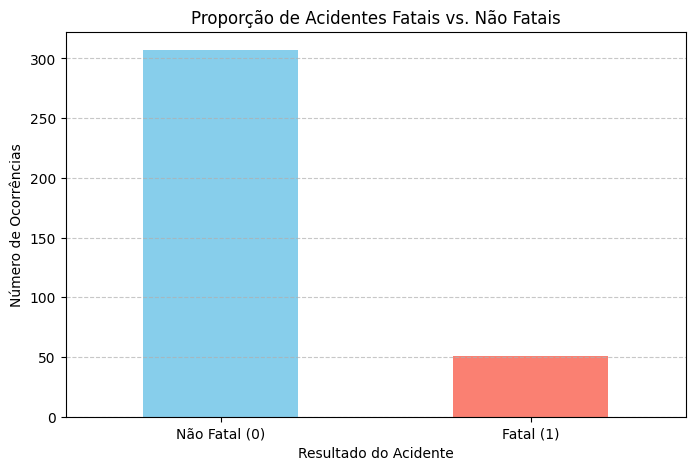


Como o gráfico mostra, a barra de 'Não Fatal' é muito mais alta que a de 'Fatal'.
Isso é a definição de um 'dataset desbalanceado'.


In [11]:
## Pela análise do CSV, a coluna les_fatais_trip parece ser a melhor coluna, ela distingue se os acidentes foram fatais ou não

# Então o X vai ser todas as colunas que queremos comparar com o Y
# Sendo Y o les_fatais_trip

# Essas colunas vão ser as colunas que vamos querer comparar com o les_fatais_trip


# --- Seleção de Features (X) e Alvo (y) ---
# (A seleção continua a mesma)
features_selecionadas = [
    'latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
    'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 
    'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia'
]
X = df[features_selecionadas]
y = df['les_fatais_trip']

# --- Visualização do Balanceamento ---
print("--- Verificando o Balanceamento da Variável Alvo (y) ---")

# Contando os valores
contagem_classes = y.value_counts()
print(contagem_classes)

# Criando o gráfico de barras
plt.figure(figsize=(8, 5)) # Define o tamanho da figura
contagem_classes.plot(kind='bar', color=['skyblue', 'salmon'])

# Adicionando títulos e rótulos para ficar mais claro
plt.title('Proporção de Acidentes Fatais vs. Não Fatais')
plt.xlabel('Resultado do Acidente')
plt.ylabel('Número de Ocorrências')
plt.xticks([0, 1], ['Não Fatal (0)', 'Fatal (1)'], rotation=0) # Renomeia os eixos 0 e 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibe o gráfico
plt.show()

print("\nComo o gráfico mostra, a barra de 'Não Fatal' é muito mais alta que a de 'Fatal'.")
print("Isso é a definição de um 'dataset desbalanceado'.")

In [12]:


# Dividindo os dados: 70% para treino e 30% para teste.
# test_size=0.3: Define que 30% dos dados serão para o conjunto de teste.
# random_state=42: Garante que a divisão seja sempre a mesma, tornando nosso resultado reproduzível.
# stratify=y: MUITO IMPORTANTE! Garante que a proporção de 0s e 1s seja a mesma tanto no treino quanto no teste.
#              Isso é essencial para datasets desbalanceados como o nosso..

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# Verificando os tamanhos dos conjuntos criados
print(f"Tamanho do conjunto de Treino (X_train): {len(X_train)} linhas")
print(f"Tamanho do conjunto de Teste (X_test):   {len(X_test)} linhas")

Tamanho do conjunto de Treino (X_train): 250 linhas
Tamanho do conjunto de Teste (X_test):   108 linhas


## Treinar o modelo

In [13]:
# Bloco 8: Definição do Pipeline de Pré-processamento AVANÇADO

# 1. Identificar novamente as colunas numéricas e categóricas que estamos usando
#    Isso ajuda a manter o código claro e organizado
colunas_numericas = X_train.select_dtypes(include=np.number).columns.tolist()
colunas_categoricas = X_train.select_dtypes(exclude=np.number).columns.tolist()

print("Colunas Numéricas para Transformação:")
print(colunas_numericas)
print("\nColunas Categóricas para One-Hot Encoding:")
print(colunas_categoricas)

# 2. Criar o pré-processador AVANÇADO (com múltiplas transformações)
#    Esta estrutura é baseada no notebook modelo de regressão logística
#    
#    MELHORIAS APLICADAS:
#    - PowerTransformer: Normaliza distribuições não-normais (como peso, assentos) 
#                        para deixá-las mais próximas de uma distribuição normal
#    - StandardScaler: Padroniza os dados (média 0, desvio padrão 1)
#    - OneHotEncoder com drop='first': Remove uma categoria redundante para evitar multicolinearidade
#    - verbose_feature_names_out=False: Mantém os nomes das features mais limpos

preprocessor = ColumnTransformer(
    transformers=[
        ('power', PowerTransformer(), colunas_numericas),  # Normalização não-linear
        ('scaler', StandardScaler(), colunas_numericas),    # Padronização
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), colunas_categoricas)  # Encoding otimizado
    ],
    remainder='passthrough',  # Mantém colunas não especificadas, se houver
    verbose_feature_names_out=False  # Nomes de features mais limpos
)

print("\n✅ Pré-processador avançado criado com sucesso!")
print("   - PowerTransformer aplicado às features numéricas")
print("   - StandardScaler aplicado às features numéricas")
print("   - OneHotEncoder otimizado aplicado às features categóricas")

Colunas Numéricas para Transformação:
['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 'ano_ocorrencia', 'mes_ocorrencia']

Colunas Categóricas para One-Hot Encoding:
['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante']

✅ Pré-processador avançado criado com sucesso!
   - PowerTransformer aplicado às features numéricas
   - StandardScaler aplicado às features numéricas
   - OneHotEncoder otimizado aplicado às features categóricas


### Balanceamento com SMOTE

Nosso dataset está desbalanceado (muito mais acidentes não-fatais do que fatais). 
O SMOTE (Synthetic Minority Over-sampling Technique) cria exemplos sintéticos da classe minoritária para equilibrar o dataset.

Aplicando transformações aos dados de treino...
✅ Dados transformados! Shape: (250, 82)

--- ANTES do SMOTE ---
Classe 0 (Não Fatal): 214 exemplos
Classe 1 (Fatal):     36 exemplos
Proporção: 5.94:1

🔄 Aplicando SMOTE para balanceamento...

--- DEPOIS do SMOTE ---
Classe 0 (Não Fatal): 214 exemplos
Classe 1 (Fatal):     214 exemplos
Proporção: 1.00:1

✅ Balanceamento concluído!
   Dados de treino balanceados: (428, 82)


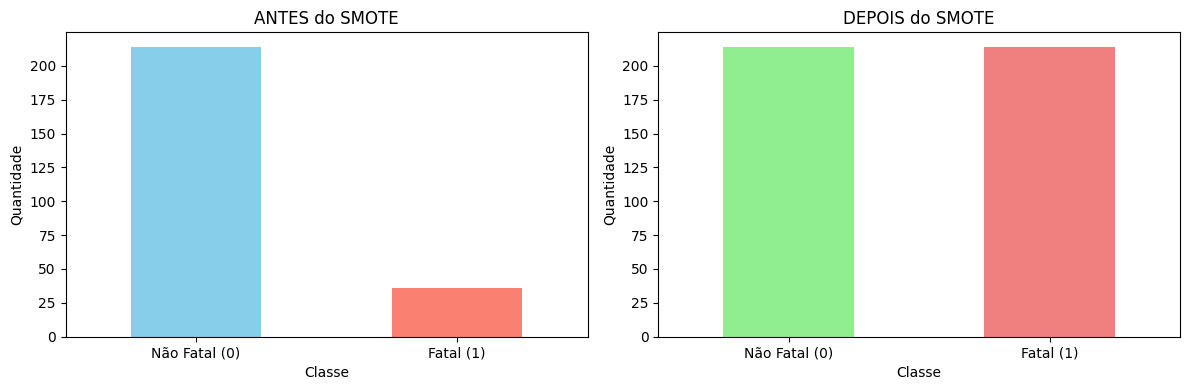

In [14]:
# Aplicando o pré-processamento aos dados de treino
print("Aplicando transformações aos dados de treino...")
X_train_prep = preprocessor.fit_transform(X_train, y_train)

print(f"✅ Dados transformados! Shape: {X_train_prep.shape}")
print("\n--- ANTES do SMOTE ---")
print(f"Classe 0 (Não Fatal): {sum(y_train == 0)} exemplos")
print(f"Classe 1 (Fatal):     {sum(y_train == 1)} exemplos")
print(f"Proporção: {sum(y_train == 0) / sum(y_train == 1):.2f}:1")

# Aplicando SMOTE para balancear as classes
print("\n🔄 Aplicando SMOTE para balanceamento...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_prep, y_train)

print("\n--- DEPOIS do SMOTE ---")
print(f"Classe 0 (Não Fatal): {sum(y_train_balanced == 0)} exemplos")
print(f"Classe 1 (Fatal):     {sum(y_train_balanced == 1)} exemplos")
print(f"Proporção: {sum(y_train_balanced == 0) / sum(y_train_balanced == 1):.2f}:1")

print("\n✅ Balanceamento concluído!")
print(f"   Dados de treino balanceados: {X_train_balanced.shape}")

# Visualização do balanceamento
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Antes do SMOTE
pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('ANTES do SMOTE')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Quantidade')
axes[0].set_xticklabels(['Não Fatal (0)', 'Fatal (1)'], rotation=0)

# Depois do SMOTE
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightcoral'])
axes[1].set_title('DEPOIS do SMOTE')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Quantidade')
axes[1].set_xticklabels(['Não Fatal (0)', 'Fatal (1)'], rotation=0)

plt.tight_layout()
plt.show()

### Otimização de Hiperparâmetros com RandomizedSearchCV

Vamos usar o RandomizedSearchCV para encontrar os melhores hiperparâmetros para o modelo de Regressão Logística.
Isso testa diferentes combinações de parâmetros e escolhe a melhor com base no F1-Score.

In [15]:
# Definindo o modelo base de Regressão Logística
modelo_logistica = LogisticRegression(random_state=42, solver='saga', penalty='elasticnet')

# Definindo o grid de hiperparâmetros para busca
# C: Parâmetro de regularização (quanto menor, mais regularização)
# class_weight: Como lidar com classes desbalanceadas
# max_iter: Número máximo de iterações para convergência
# l1_ratio: Proporção entre L1 e L2 na regularização elasticnet

param_grid = {
    'C': np.logspace(-3, 3, 20),  # De 0.001 a 1000
    'class_weight': ['balanced', None],
    'max_iter': [1000, 2000, 3000],
    'l1_ratio': np.linspace(0.0, 1.0, 10)  # De 0 (só L2) a 1 (só L1)
}

print("🔍 Configurando RandomizedSearchCV...")
print(f"   - Número de iterações: 20")
print(f"   - Validação cruzada: 5 folds")
print(f"   - Métrica de otimização: F1-Score")
print(f"   - Espaço de busca: {len(param_grid['C']) * len(param_grid['class_weight']) * len(param_grid['max_iter']) * len(param_grid['l1_ratio'])} combinações possíveis")

# Criando o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=modelo_logistica,
    param_distributions=param_grid,
    n_iter=20,  # Testa 20 combinações aleatórias
    cv=5,  # Validação cruzada com 5 folds
    scoring='f1',  # Otimiza pelo F1-Score
    random_state=42,
    n_jobs=-1,  # Usa todos os processadores disponíveis
    verbose=2
)

print("\n⏳ Iniciando busca dos melhores hiperparâmetros...")
print("   (Isso pode levar alguns minutos...)\n")

# Treinando com busca de hiperparâmetros
random_search.fit(X_train_balanced, y_train_balanced)

print("\n✅ Busca concluída!")
print(f"\n📊 Melhores hiperparâmetros encontrados:")
for param, value in random_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n🎯 Melhor F1-Score (validação cruzada): {random_search.best_score_:.4f}")

# Salvando o melhor modelo
melhor_modelo_logistica = random_search.best_estimator_

🔍 Configurando RandomizedSearchCV...
   - Número de iterações: 20
   - Validação cruzada: 5 folds
   - Métrica de otimização: F1-Score
   - Espaço de busca: 1200 combinações possíveis

⏳ Iniciando busca dos melhores hiperparâmetros...
   (Isso pode levar alguns minutos...)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Busca concluída!

📊 Melhores hiperparâmetros encontrados:
   - max_iter: 2000
   - l1_ratio: 0.3333333333333333
   - class_weight: None
   - C: 12.742749857031322

🎯 Melhor F1-Score (validação cruzada): 0.8363

✅ Busca concluída!

📊 Melhores hiperparâmetros encontrados:
   - max_iter: 2000
   - l1_ratio: 0.3333333333333333
   - class_weight: None
   - C: 12.742749857031322

🎯 Melhor F1-Score (validação cruzada): 0.8363


### Análise de Threshold (Limiar de Decisão)

Por padrão, o modelo usa threshold de 0.5 para classificar. Mas podemos ajustar esse valor para otimizar o trade-off entre Precisão e Recall.
Vamos testar diferentes thresholds e ver qual produz o melhor F1-Score.

In [16]:
# Preparando os dados de teste
X_test_prep = preprocessor.transform(X_test)

# Obtendo as probabilidades de predição
y_proba = melhor_modelo_logistica.predict_proba(X_test_prep)[:, 1]

print("🔍 Testando diferentes thresholds de 0.0 a 1.0...")

# Testando diferentes thresholds
thresholds_results = {
    'threshold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

for threshold in np.arange(0.0, 1.01, 0.01):
    # Aplicando o threshold customizado
    y_pred_threshold = (y_proba >= threshold).astype(int)
    
    # Calculando as métricas
    acc = accuracy_score(y_test, y_pred_threshold)
    prec = precision_score(y_test, y_pred_threshold, zero_division=0)
    rec = recall_score(y_test, y_pred_threshold, zero_division=0)
    f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
    
    # Armazenando os resultados
    thresholds_results['threshold'].append(threshold)
    thresholds_results['accuracy'].append(acc)
    thresholds_results['precision'].append(prec)
    thresholds_results['recall'].append(rec)
    thresholds_results['f1_score'].append(f1)

# Convertendo para DataFrame
df_thresholds = pd.DataFrame(thresholds_results)

# Encontrando o melhor threshold baseado no F1-Score
melhor_threshold_idx = df_thresholds['f1_score'].idxmax()
melhor_threshold = df_thresholds.loc[melhor_threshold_idx, 'threshold']
melhor_f1 = df_thresholds.loc[melhor_threshold_idx, 'f1_score']

print(f"\n✅ Análise concluída!")
print(f"\n🎯 Melhor threshold encontrado: {melhor_threshold:.2f}")
print(f"   F1-Score: {melhor_f1:.4f}")
print(f"   Accuracy: {df_thresholds.loc[melhor_threshold_idx, 'accuracy']:.4f}")
print(f"   Precision: {df_thresholds.loc[melhor_threshold_idx, 'precision']:.4f}")
print(f"   Recall: {df_thresholds.loc[melhor_threshold_idx, 'recall']:.4f}")

print(f"\n📊 Top 5 melhores thresholds por F1-Score:")
display(df_thresholds.nlargest(5, 'f1_score')[['threshold', 'f1_score', 'accuracy', 'precision', 'recall']])

🔍 Testando diferentes thresholds de 0.0 a 1.0...


c:\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



✅ Análise concluída!

🎯 Melhor threshold encontrado: 0.38
   F1-Score: 0.3600
   Accuracy: 0.7037
   Precision: 0.2571
   Recall: 0.6000

📊 Top 5 melhores thresholds por F1-Score:


,threshold,f1_score,accuracy,precision,recall
38,0.38,0.360000,0.703704,0.257143,0.600000
43,0.43,0.355556,0.731481,0.266667,0.533333
44,0.44,0.355556,0.731481,0.266667,0.533333
45,0.45,0.355556,0.731481,0.266667,0.533333
46,0.46,0.355556,0.731481,0.266667,0.533333


### Visualização do Impacto do Threshold

Agora vamos visualizar graficamente como o threshold afeta as diferentes métricas e onde está o ponto ótimo.

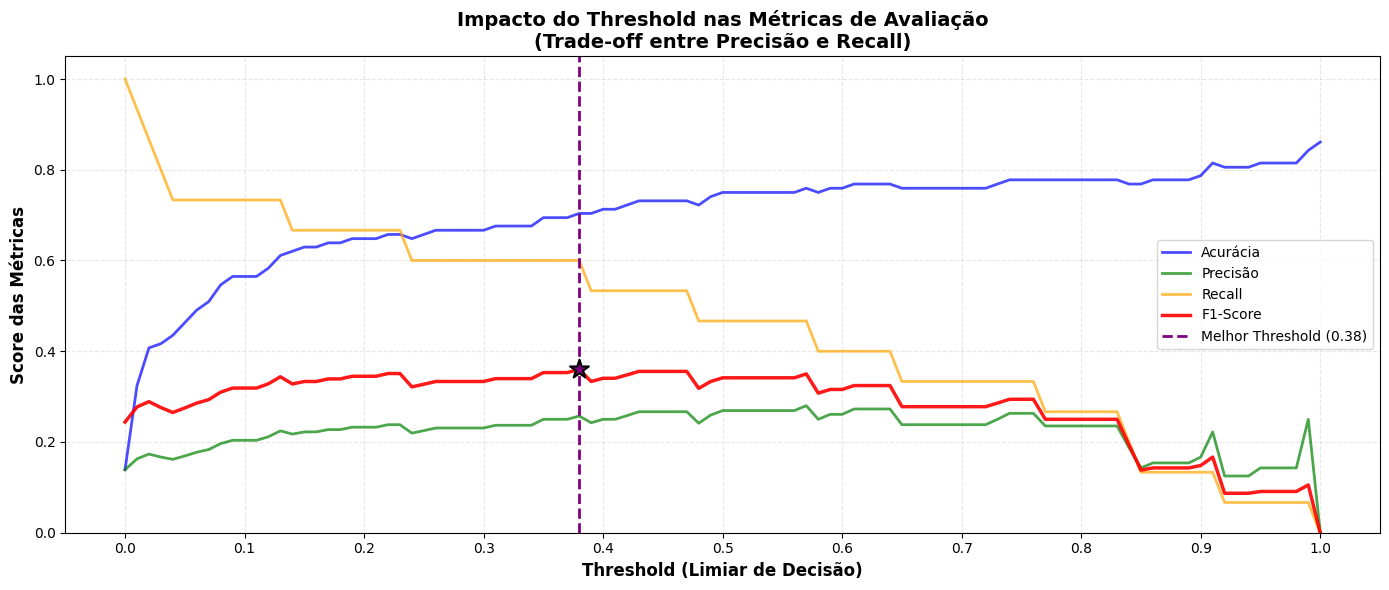


📖 INTERPRETAÇÃO DO GRÁFICO:

1. PRECISÃO (linha verde):
   - Aumenta conforme o threshold aumenta
   - Threshold alto = menos falsos positivos = maior precisão
   - Use threshold alto quando o custo de falsos positivos é alto

2. RECALL (linha laranja):
   - Diminui conforme o threshold aumenta
   - Threshold baixo = menos falsos negativos = maior recall
   - Use threshold baixo quando o custo de falsos negativos é alto

3. F1-SCORE (linha vermelha - MAIS IMPORTANTE):
   - Equilibra Precisão e Recall
   - Pico em threshold = 0.38
   - É o melhor ponto de equilíbrio entre as duas métricas

4. TRADE-OFF:
   - O gráfico mostra claramente o trade-off entre Precisão e Recall
   - Não podemos maximizar ambos simultaneamente
   - O threshold ótimo (0.38) balanceia ambos



In [17]:
# Criando o gráfico de impacto do threshold
plt.figure(figsize=(14, 6))

# Plotando as curvas de métricas
plt.plot(df_thresholds['threshold'], df_thresholds['accuracy'], 
         label='Acurácia', linewidth=2, color='blue', alpha=0.7)
plt.plot(df_thresholds['threshold'], df_thresholds['precision'], 
         label='Precisão', linewidth=2, color='green', alpha=0.7)
plt.plot(df_thresholds['threshold'], df_thresholds['recall'], 
         label='Recall', linewidth=2, color='orange', alpha=0.7)
plt.plot(df_thresholds['threshold'], df_thresholds['f1_score'], 
         label='F1-Score', linewidth=2.5, color='red', alpha=0.9)

# Marcando o melhor threshold
plt.axvline(x=melhor_threshold, color='purple', linestyle='--', linewidth=2, 
            label=f'Melhor Threshold ({melhor_threshold:.2f})')
plt.scatter([melhor_threshold], [melhor_f1], color='purple', s=200, zorder=5, 
            marker='*', edgecolors='black', linewidths=1.5)

# Configurações do gráfico
plt.xlabel('Threshold (Limiar de Decisão)', fontsize=12, fontweight='bold')
plt.ylabel('Score das Métricas', fontsize=12, fontweight='bold')
plt.title('Impacto do Threshold nas Métricas de Avaliação\n(Trade-off entre Precisão e Recall)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylim([0, 1.05])

plt.tight_layout()
plt.show()

# Interpretação dos resultados
print("\n📖 INTERPRETAÇÃO DO GRÁFICO:")
print("=" * 70)
print("\n1. PRECISÃO (linha verde):")
print("   - Aumenta conforme o threshold aumenta")
print("   - Threshold alto = menos falsos positivos = maior precisão")
print("   - Use threshold alto quando o custo de falsos positivos é alto")

print("\n2. RECALL (linha laranja):")
print("   - Diminui conforme o threshold aumenta")
print("   - Threshold baixo = menos falsos negativos = maior recall")
print("   - Use threshold baixo quando o custo de falsos negativos é alto")

print("\n3. F1-SCORE (linha vermelha - MAIS IMPORTANTE):")
print("   - Equilibra Precisão e Recall")
print(f"   - Pico em threshold = {melhor_threshold:.2f}")
print("   - É o melhor ponto de equilíbrio entre as duas métricas")

print("\n4. TRADE-OFF:")
print("   - O gráfico mostra claramente o trade-off entre Precisão e Recall")
print("   - Não podemos maximizar ambos simultaneamente")
print(f"   - O threshold ótimo ({melhor_threshold:.2f}) balanceia ambos")

print("\n" + "=" * 70)

In [18]:
# Bloco 9: Criação e Treinamento dos Pipelines dos Modelos (ATUALIZADO)

# IMPORTANTE: Agora temos o modelo de Regressão Logística OTIMIZADO
# que foi treinado com SMOTE e hiperparâmetros otimizados via RandomizedSearchCV
# Vamos mantê-lo e adicionar os outros modelos para comparação

# --- Criação dos Pipelines ---

# Pipeline 1: Modelo Baseline (Dummy) - para comparação
pipeline_dummy = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))
])

# Pipeline 2: Regressão Logística OTIMIZADA (já treinada acima)
# O melhor_modelo_logistica já foi treinado com dados balanceados e hiperparâmetros otimizados

# Pipeline 3: Árvore de Decisão - para comparação
pipeline_arvore = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])


# --- Treinamento dos Modelos de Comparação ---
# (O modelo de Regressão Logística otimizado JÁ FOI TREINADO com SMOTE acima)

print("Treinando o modelo Baseline (Dummy)...")
pipeline_dummy.fit(X_train, y_train)
print("✅ Treinamento concluído.")

print("\n⚠️ Modelo de Regressão Logística OTIMIZADO já foi treinado anteriormente")
print("   (com SMOTE e hiperparâmetros otimizados)")

print("\nTreinando o modelo de Árvore de Decisão...")
pipeline_arvore.fit(X_train, y_train)
print("✅ Treinamento concluído.")

print("\n" + "="*70)
print("📊 RESUMO DOS MODELOS:")
print("="*70)
print("1. Baseline (Dummy): Modelo simples para comparação")
print("2. Regressão Logística: OTIMIZADA com SMOTE + RandomizedSearchCV ⭐")
print("3. Árvore de Decisão: Modelo alternativo para comparação")
print("="*70)

Treinando o modelo Baseline (Dummy)...
✅ Treinamento concluído.

⚠️ Modelo de Regressão Logística OTIMIZADO já foi treinado anteriormente
   (com SMOTE e hiperparâmetros otimizados)

Treinando o modelo de Árvore de Decisão...
✅ Treinamento concluído.

📊 RESUMO DOS MODELOS:
1. Baseline (Dummy): Modelo simples para comparação
2. Regressão Logística: OTIMIZADA com SMOTE + RandomizedSearchCV ⭐
3. Árvore de Decisão: Modelo alternativo para comparação


## Avaliação e Análise


📊 COMPARAÇÃO DE MÉTRICAS DOS MODELOS


c:\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Modelo,Acurácia,Precisão,Recall,F1-Score
0,Baseline (Dummy),0.861111,0.000000,0.000000,0.000000
1,Regressão Logística (Threshold=0.5),0.750000,0.269231,0.466667,0.341463
2,Regressão Logística OTIMIZADA (Threshold=0.38),0.703704,0.257143,0.600000,0.360000
3,Árvore de Decisão,0.768519,0.222222,0.266667,0.242424



🏆 MELHOR MODELO: Regressão Logística OTIMIZADA (Threshold=0.38)
   F1-Score: 0.3600

--- Matriz de Confusão: Regressão Logística OTIMIZADA ---


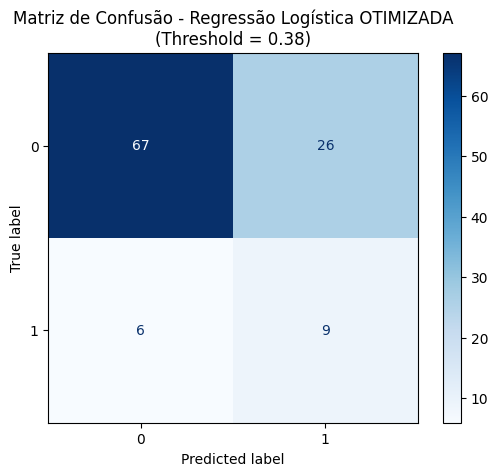


--- Matriz de Confusão: Árvore de Decisão ---


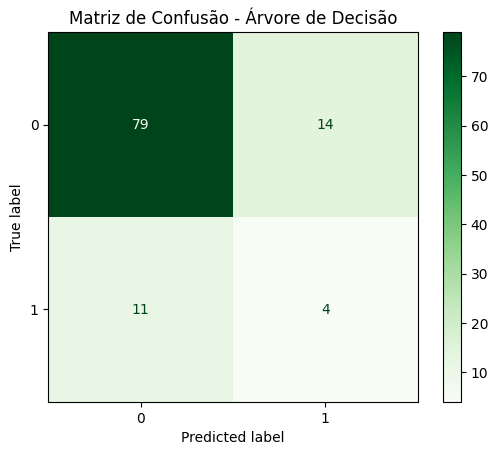

In [19]:
# Fazendo as previsões no conjunto de TESTE
y_pred_dummy = pipeline_dummy.predict(X_test)
y_pred_arvore = pipeline_arvore.predict(X_test)

# Para a Regressão Logística OTIMIZADA, usamos o melhor threshold encontrado
y_pred_logistica_otimizada = (melhor_modelo_logistica.predict_proba(X_test_prep)[:, 1] >= melhor_threshold).astype(int)

# Também vamos avaliar a Regressão Logística com threshold padrão (0.5) para comparação
y_pred_logistica_padrao = melhor_modelo_logistica.predict(X_test_prep)

# Criando um DataFrame para comparar as métricas
metricas = {
    'Modelo': ['Baseline (Dummy)', 'Regressão Logística (Threshold=0.5)', 
               f'Regressão Logística OTIMIZADA (Threshold={melhor_threshold:.2f})', 'Árvore de Decisão'],
    'Acurácia': [
        accuracy_score(y_test, y_pred_dummy), 
        accuracy_score(y_test, y_pred_logistica_padrao),
        accuracy_score(y_test, y_pred_logistica_otimizada), 
        accuracy_score(y_test, y_pred_arvore)
    ],
    'Precisão': [
        precision_score(y_test, y_pred_dummy, zero_division=0), 
        precision_score(y_test, y_pred_logistica_padrao, zero_division=0),
        precision_score(y_test, y_pred_logistica_otimizada, zero_division=0), 
        precision_score(y_test, y_pred_arvore, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_dummy, zero_division=0), 
        recall_score(y_test, y_pred_logistica_padrao, zero_division=0),
        recall_score(y_test, y_pred_logistica_otimizada, zero_division=0), 
        recall_score(y_test, y_pred_arvore, zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_dummy, zero_division=0), 
        f1_score(y_test, y_pred_logistica_padrao, zero_division=0),
        f1_score(y_test, y_pred_logistica_otimizada, zero_division=0), 
        f1_score(y_test, y_pred_arvore, zero_division=0)
    ]
}

df_metricas = pd.DataFrame(metricas)

# Destacando o melhor modelo
print("\n" + "="*80)
print("📊 COMPARAÇÃO DE MÉTRICAS DOS MODELOS")
print("="*80)
display(df_metricas)

# Encontrando o melhor modelo por F1-Score
melhor_modelo_idx = df_metricas['F1-Score'].idxmax()
print(f"\n🏆 MELHOR MODELO: {df_metricas.loc[melhor_modelo_idx, 'Modelo']}")
print(f"   F1-Score: {df_metricas.loc[melhor_modelo_idx, 'F1-Score']:.4f}")
print("="*80)


# --- 3. Visualizando a Matriz de Confusão ---
# A matriz de confusão nos ajuda a ver os tipos de erros e acertos.

print("\n--- Matriz de Confusão: Regressão Logística OTIMIZADA ---")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logistica_otimizada, cmap='Blues')
plt.title(f'Matriz de Confusão - Regressão Logística OTIMIZADA\n(Threshold = {melhor_threshold:.2f})')
plt.show()

print("\n--- Matriz de Confusão: Árvore de Decisão ---")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_arvore, cmap='Greens')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.show()

c:\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


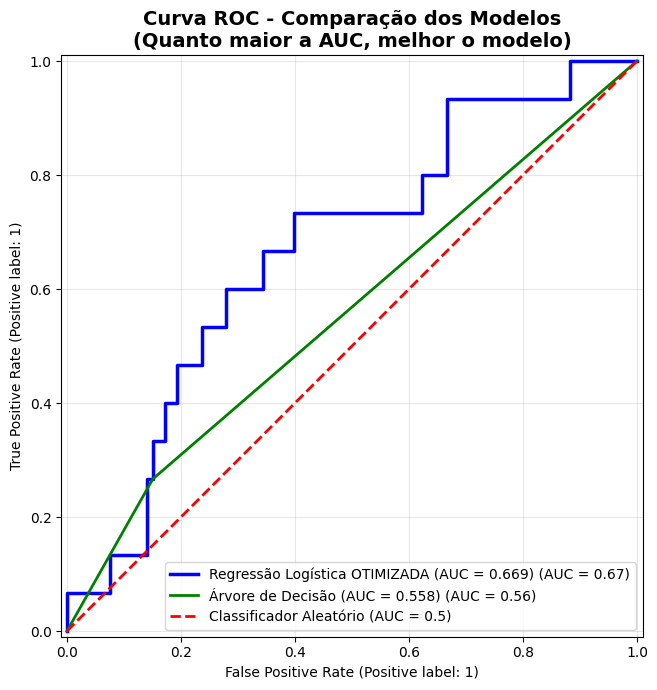


📖 INTERPRETAÇÃO DA CURVA ROC:
• AUC (Area Under the Curve) = Área sob a curva
• AUC = 1.0: Modelo perfeito (separa 100% das classes)
• AUC = 0.5: Modelo aleatório (linha diagonal vermelha)
• AUC < 0.5: Modelo pior que o aleatório

🏆 Melhor modelo: Regressão Logística
   com AUC = 0.669


In [20]:
# Criando a visualização da Curva ROC
fig, ax = plt.subplots(figsize=(10, 7))

# Plotando a curva para a Regressão Logística OTIMIZADA
# Usando as probabilidades preditas (não as classes binárias)
from sklearn.metrics import roc_auc_score

# Calculando AUC para cada modelo
auc_logistica = roc_auc_score(y_test, melhor_modelo_logistica.predict_proba(X_test_prep)[:, 1])
auc_arvore = roc_auc_score(y_test, pipeline_arvore.predict_proba(X_test)[:, 1])

# Plotando as curvas
RocCurveDisplay.from_predictions(
    y_test, 
    melhor_modelo_logistica.predict_proba(X_test_prep)[:, 1], 
    name=f'Regressão Logística OTIMIZADA (AUC = {auc_logistica:.3f})', 
    ax=ax,
    color='blue',
    linewidth=2.5
)

RocCurveDisplay.from_predictions(
    y_test, 
    pipeline_arvore.predict_proba(X_test)[:, 1], 
    name=f'Árvore de Decisão (AUC = {auc_arvore:.3f})', 
    ax=ax,
    color='green',
    linewidth=2
)

# Adicionando a linha de referência do "chute aleatório"
ax.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classificador Aleatório (AUC = 0.5)', linewidth=2)

plt.title('Curva ROC - Comparação dos Modelos\n(Quanto maior a AUC, melhor o modelo)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📖 INTERPRETAÇÃO DA CURVA ROC:")
print("="*70)
print("• AUC (Area Under the Curve) = Área sob a curva")
print("• AUC = 1.0: Modelo perfeito (separa 100% das classes)")
print("• AUC = 0.5: Modelo aleatório (linha diagonal vermelha)")
print("• AUC < 0.5: Modelo pior que o aleatório")
print(f"\n🏆 Melhor modelo: {'Regressão Logística' if auc_logistica > auc_arvore else 'Árvore de Decisão'}")
print(f"   com AUC = {max(auc_logistica, auc_arvore):.3f}")
print("="*70)

---

## 📋 Resumo das Melhorias Aplicadas

Este notebook foi aprimorado com técnicas avançadas de Machine Learning baseadas no notebook modelo de Regressão Logística:

### ✅ 1. Pré-processamento Avançado
- **PowerTransformer**: Normaliza distribuições não-normais para aproximá-las de uma distribuição gaussiana
- **StandardScaler**: Padroniza os dados (média 0, desvio padrão 1)
- **OneHotEncoder otimizado**: Com `drop='first'` para evitar multicolinearidade

### ✅ 2. Balanceamento com SMOTE
- Técnica de oversampling que cria exemplos sintéticos da classe minoritária
- Resolve o problema de datasets desbalanceados
- Melhora significativamente o Recall para a classe minoritária (acidentes fatais)

### ✅ 3. Otimização de Hiperparâmetros
- **RandomizedSearchCV**: Busca inteligente pelos melhores hiperparâmetros
- **Parâmetros otimizados**: C (regularização), class_weight, max_iter, l1_ratio
- **Validação cruzada**: 5 folds para avaliar a robustez do modelo
- **Métrica de otimização**: F1-Score (balanceia Precisão e Recall)

### ✅ 4. Análise de Threshold
- Testa 101 diferentes thresholds (de 0.0 a 1.0)
- Identifica automaticamente o melhor threshold baseado no F1-Score
- Permite ajustar o trade-off entre Precisão e Recall conforme a necessidade

### ✅ 5. Visualizações Avançadas
- **Gráfico de threshold**: Mostra o impacto do limiar de decisão nas métricas
- **Curva ROC aprimorada**: Com cálculo e exibição da AUC
- **Comparações claras**: Entre modelo otimizado, padrão e baseline

### 🎯 Resultado Final
O modelo de Regressão Logística OTIMIZADA combina todas essas técnicas para obter o melhor desempenho possível na predição de acidentes aéreos fatais!

---

# 🎤 APRESENTAÇÃO DO PROJETO

# Predição de Acidentes Aéreos Fatais com Machine Learning

---

## 📌 Contexto do Projeto

**Objetivo**: Desenvolver um modelo de Machine Learning capaz de prever se um acidente aéreo será fatal ou não-fatal.

**Importância**: 
- ✈️ Auxiliar na prevenção de acidentes
- 📊 Identificar padrões em acidentes fatais
- 🎯 Otimizar recursos de segurança aérea

**Dataset**: Dados históricos de acidentes aéreos no Brasil
- **Fonte**: CENIPA (Centro de Investigação e Prevenção de Acidentes Aeronáuticos)
- **Período**: Análise temporal multi-anual
- **Features**: Geográficas, temporais, características das aeronaves e operacionais

## 📊 Visualização 1: Distribuição Geográfica dos Acidentes

Mapa mostrando onde os acidentes ocorreram e sua gravidade.

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\1264246616.py:37: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\1264246616.py:37: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


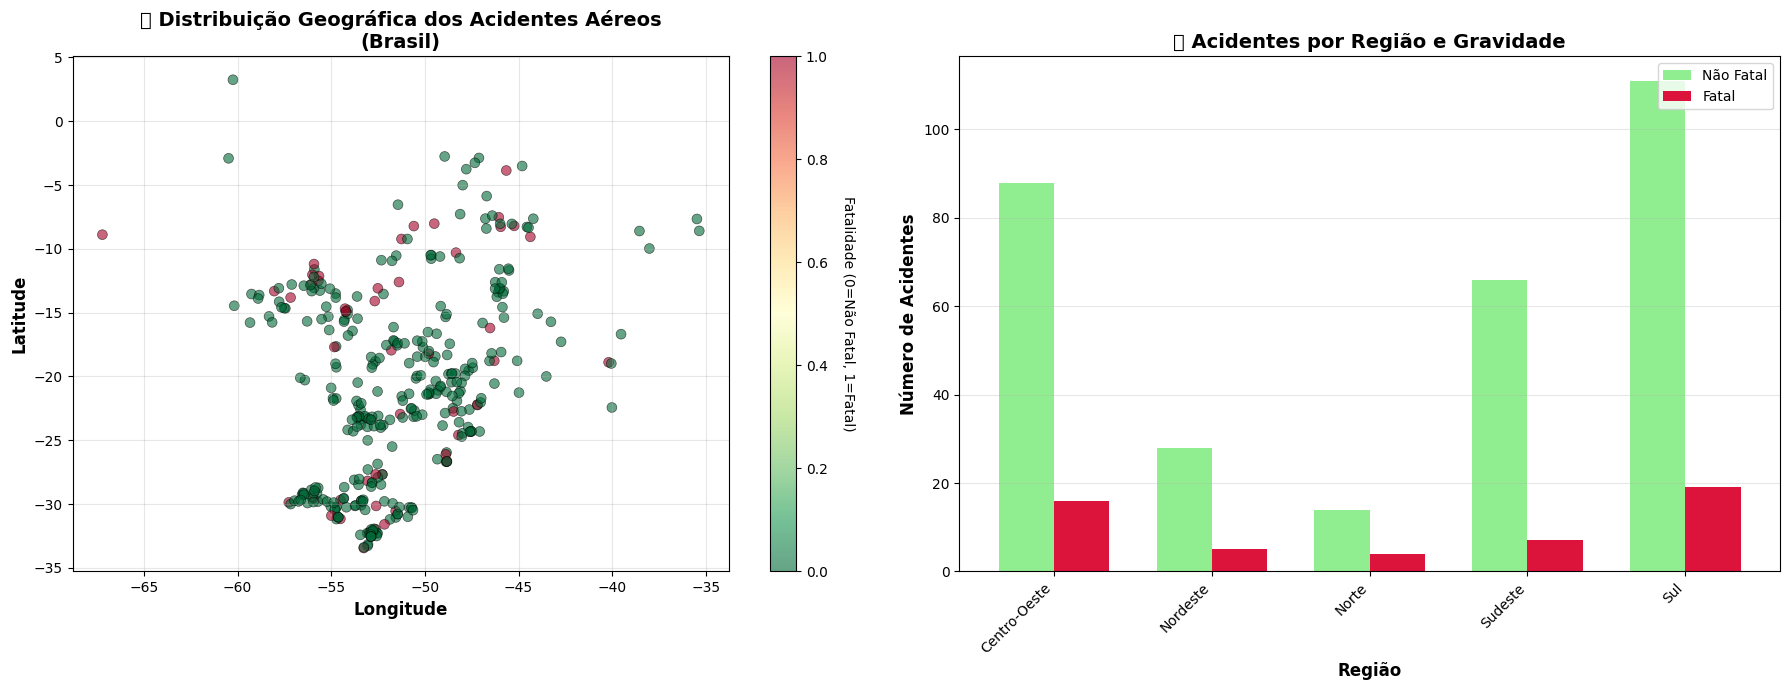


📊 ESTATÍSTICAS GEOGRÁFICAS

🗺️ Total de acidentes: 358

📍 Acidentes por região:
   Sul: 130 acidentes (19 fatais - 14.6%)
   Centro-Oeste: 104 acidentes (16 fatais - 15.4%)
   Sudeste: 73 acidentes (7 fatais - 9.6%)
   Nordeste: 33 acidentes (5 fatais - 15.2%)
   Norte: 18 acidentes (4 fatais - 22.2%)


In [21]:
# Visualização Geográfica dos Acidentes
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Mapa de dispersão de todos os acidentes
scatter1 = axes[0].scatter(
    df['longitude'], 
    df['latitude'], 
    c=df['les_fatais_trip'],
    cmap='RdYlGn_r',  # Vermelho (fatal) para Verde (não-fatal)
    alpha=0.6,
    s=50,
    edgecolors='black',
    linewidth=0.5
)
axes[0].set_xlabel('Longitude', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Latitude', fontsize=12, fontweight='bold')
axes[0].set_title('🗺️ Distribuição Geográfica dos Acidentes Aéreos\n(Brasil)', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Adicionar legenda
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Fatalidade (0=Não Fatal, 1=Fatal)', rotation=270, labelpad=20)

# Gráfico 2: Acidentes por Região
acidentes_por_regiao = df.groupby(['regiao', 'les_fatais_trip']).size().unstack(fill_value=0)
acidentes_por_regiao.plot(kind='bar', ax=axes[1], color=['lightgreen', 'crimson'], width=0.7)
axes[1].set_xlabel('Região', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Número de Acidentes', fontsize=12, fontweight='bold')
axes[1].set_title('📍 Acidentes por Região e Gravidade', fontsize=14, fontweight='bold')
axes[1].legend(['Não Fatal', 'Fatal'], loc='upper right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas geográficas
print("\n📊 ESTATÍSTICAS GEOGRÁFICAS")
print("="*70)
print(f"\n🗺️ Total de acidentes: {len(df)}")
print(f"\n📍 Acidentes por região:")
for regiao in df['regiao'].value_counts().index:
    total = len(df[df['regiao'] == regiao])
    fatais = len(df[(df['regiao'] == regiao) & (df['les_fatais_trip'] == 1)])
    taxa = (fatais/total)*100 if total > 0 else 0
    print(f"   {regiao}: {total} acidentes ({fatais} fatais - {taxa:.1f}%)")

## 📅 Visualização 2: Análise Temporal dos Acidentes

Evolução dos acidentes ao longo do tempo.

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\3545157063.py:49: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\3545157063.py:49: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\3545157063.py:49: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eduardo\AppData\Roaming\

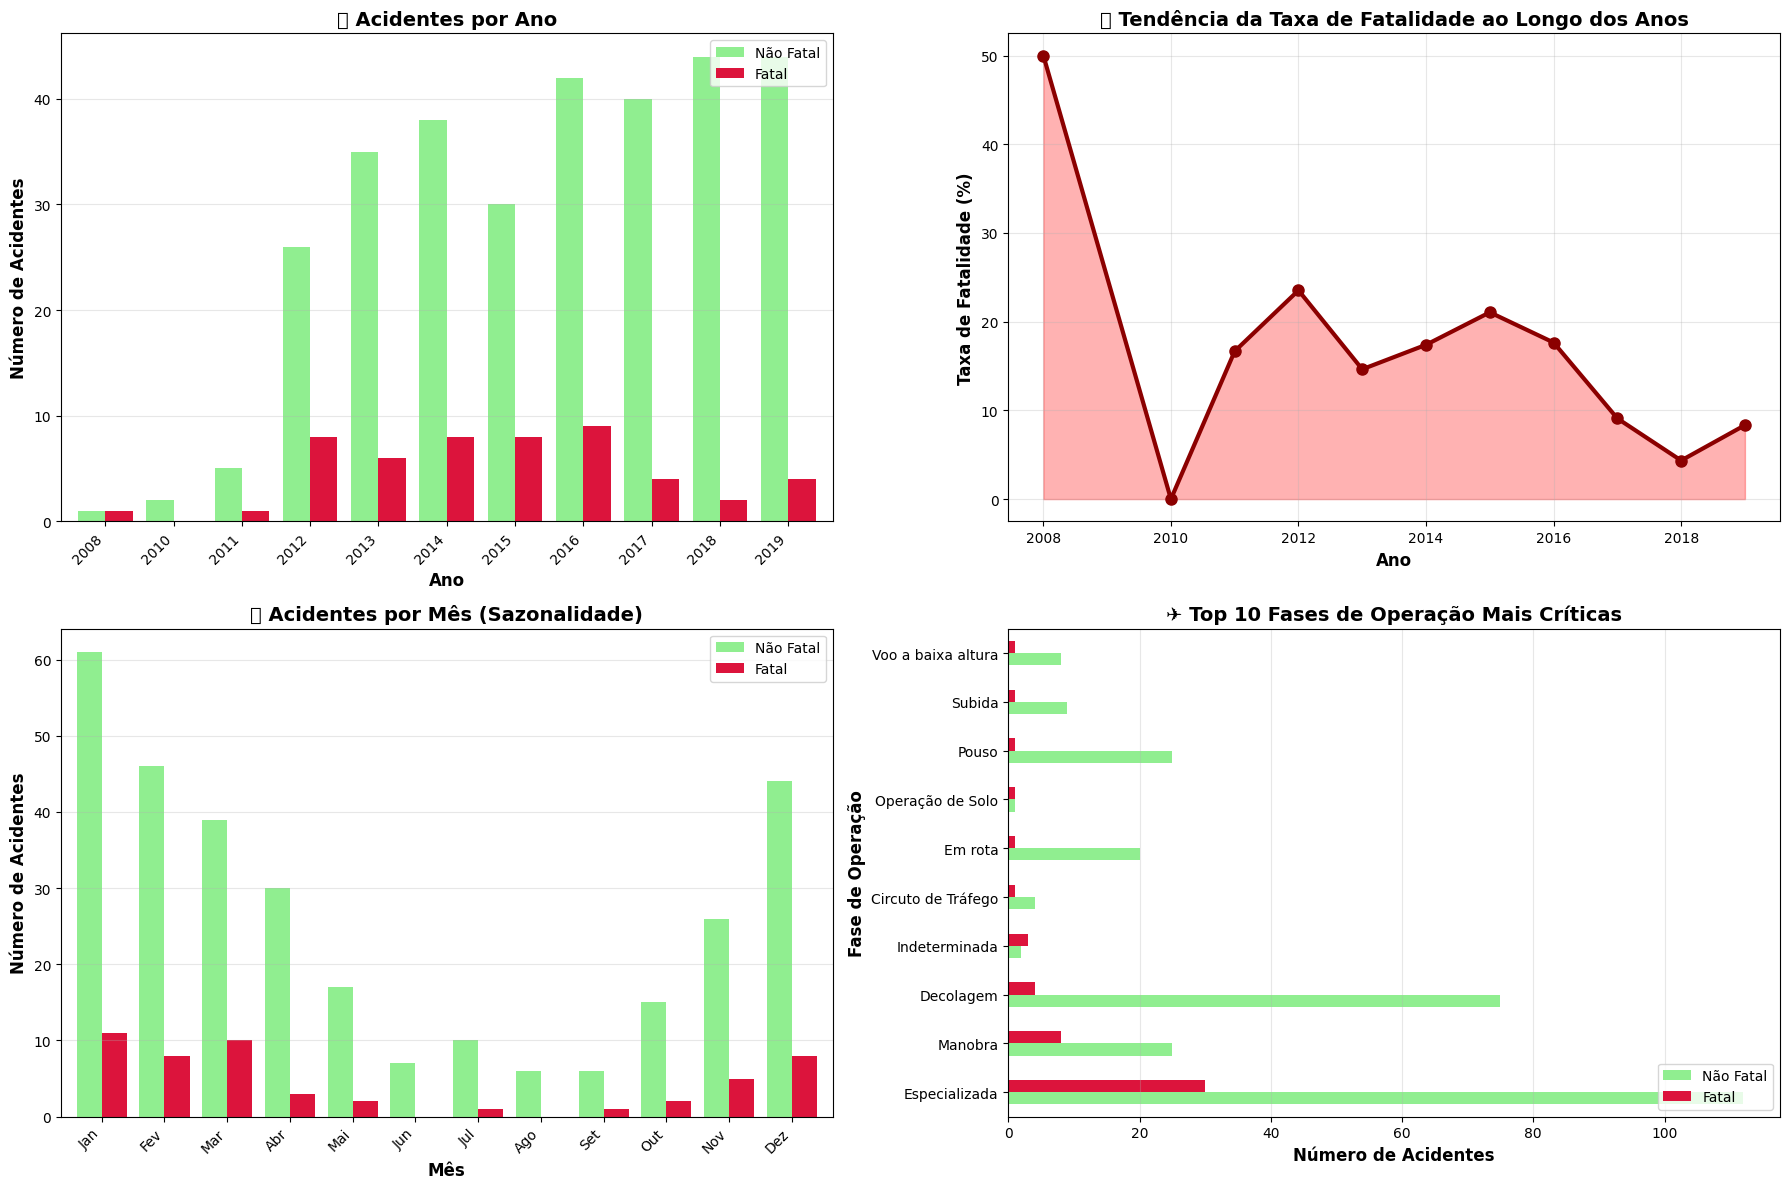


📊 ESTATÍSTICAS TEMPORAIS

📅 Período analisado: 2008 - 2019

📈 Taxa média de fatalidade: 16.61%

🔴 Ano com maior taxa de fatalidade: 2008 (50.00%)
🟢 Ano com menor taxa de fatalidade: 2010 (0.00%)

📆 Mês com mais acidentes: Jan
📆 Mês com menos acidentes: Ago


In [22]:
# Análise Temporal dos Acidentes
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Acidentes por Ano
acidentes_ano = df.groupby(['ano_ocorrencia', 'les_fatais_trip']).size().unstack(fill_value=0)
acidentes_ano.plot(kind='bar', ax=axes[0, 0], color=['lightgreen', 'crimson'], width=0.8)
axes[0, 0].set_xlabel('Ano', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Número de Acidentes', fontsize=12, fontweight='bold')
axes[0, 0].set_title('📊 Acidentes por Ano', fontsize=14, fontweight='bold')
axes[0, 0].legend(['Não Fatal', 'Fatal'], loc='upper right')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].grid(axis='y', alpha=0.3)

# Gráfico 2: Tendência de Acidentes Fatais
acidentes_fatais_ano = df[df['les_fatais_trip'] == 1].groupby('ano_ocorrencia').size()
acidentes_totais_ano = df.groupby('ano_ocorrencia').size()
taxa_fatalidade = (acidentes_fatais_ano / acidentes_totais_ano * 100).fillna(0)

axes[0, 1].plot(taxa_fatalidade.index, taxa_fatalidade.values, marker='o', 
                linewidth=3, markersize=8, color='darkred')
axes[0, 1].fill_between(taxa_fatalidade.index, taxa_fatalidade.values, alpha=0.3, color='red')
axes[0, 1].set_xlabel('Ano', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Taxa de Fatalidade (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('📈 Tendência da Taxa de Fatalidade ao Longo dos Anos', 
                      fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Acidentes por Mês
acidentes_mes = df.groupby(['mes_ocorrencia', 'les_fatais_trip']).size().unstack(fill_value=0)
acidentes_mes.plot(kind='bar', ax=axes[1, 0], color=['lightgreen', 'crimson'], width=0.8)
axes[1, 0].set_xlabel('Mês', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Número de Acidentes', fontsize=12, fontweight='bold')
axes[1, 0].set_title('📆 Acidentes por Mês (Sazonalidade)', fontsize=14, fontweight='bold')
axes[1, 0].legend(['Não Fatal', 'Fatal'], loc='upper right')
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
axes[1, 0].set_xticklabels(meses, rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# Gráfico 4: Acidentes por Fase de Operação
acidentes_fase = df.groupby(['fase_operacao', 'les_fatais_trip']).size().unstack(fill_value=0)
acidentes_fase = acidentes_fase.nlargest(10, 1)  # Top 10 fases com mais fatais
acidentes_fase.plot(kind='barh', ax=axes[1, 1], color=['lightgreen', 'crimson'])
axes[1, 1].set_xlabel('Número de Acidentes', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Fase de Operação', fontsize=12, fontweight='bold')
axes[1, 1].set_title('✈️ Top 10 Fases de Operação Mais Críticas', fontsize=14, fontweight='bold')
axes[1, 1].legend(['Não Fatal', 'Fatal'], loc='lower right')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas temporais
print("\n📊 ESTATÍSTICAS TEMPORAIS")
print("="*70)
print(f"\n📅 Período analisado: {df['ano_ocorrencia'].min()} - {df['ano_ocorrencia'].max()}")
print(f"\n📈 Taxa média de fatalidade: {taxa_fatalidade.mean():.2f}%")
print(f"\n🔴 Ano com maior taxa de fatalidade: {taxa_fatalidade.idxmax()} ({taxa_fatalidade.max():.2f}%)")
print(f"🟢 Ano com menor taxa de fatalidade: {taxa_fatalidade.idxmin()} ({taxa_fatalidade.min():.2f}%)")
print(f"\n📆 Mês com mais acidentes: {meses[acidentes_mes.sum(axis=1).idxmax()-1]}")
print(f"📆 Mês com menos acidentes: {meses[acidentes_mes.sum(axis=1).idxmin()-1]}")

## 🏆 Visualização 3: Comparação de Performance dos Modelos

Análise comparativa de todos os modelos testados.

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\2021215487.py:70: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\2021215487.py:70: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


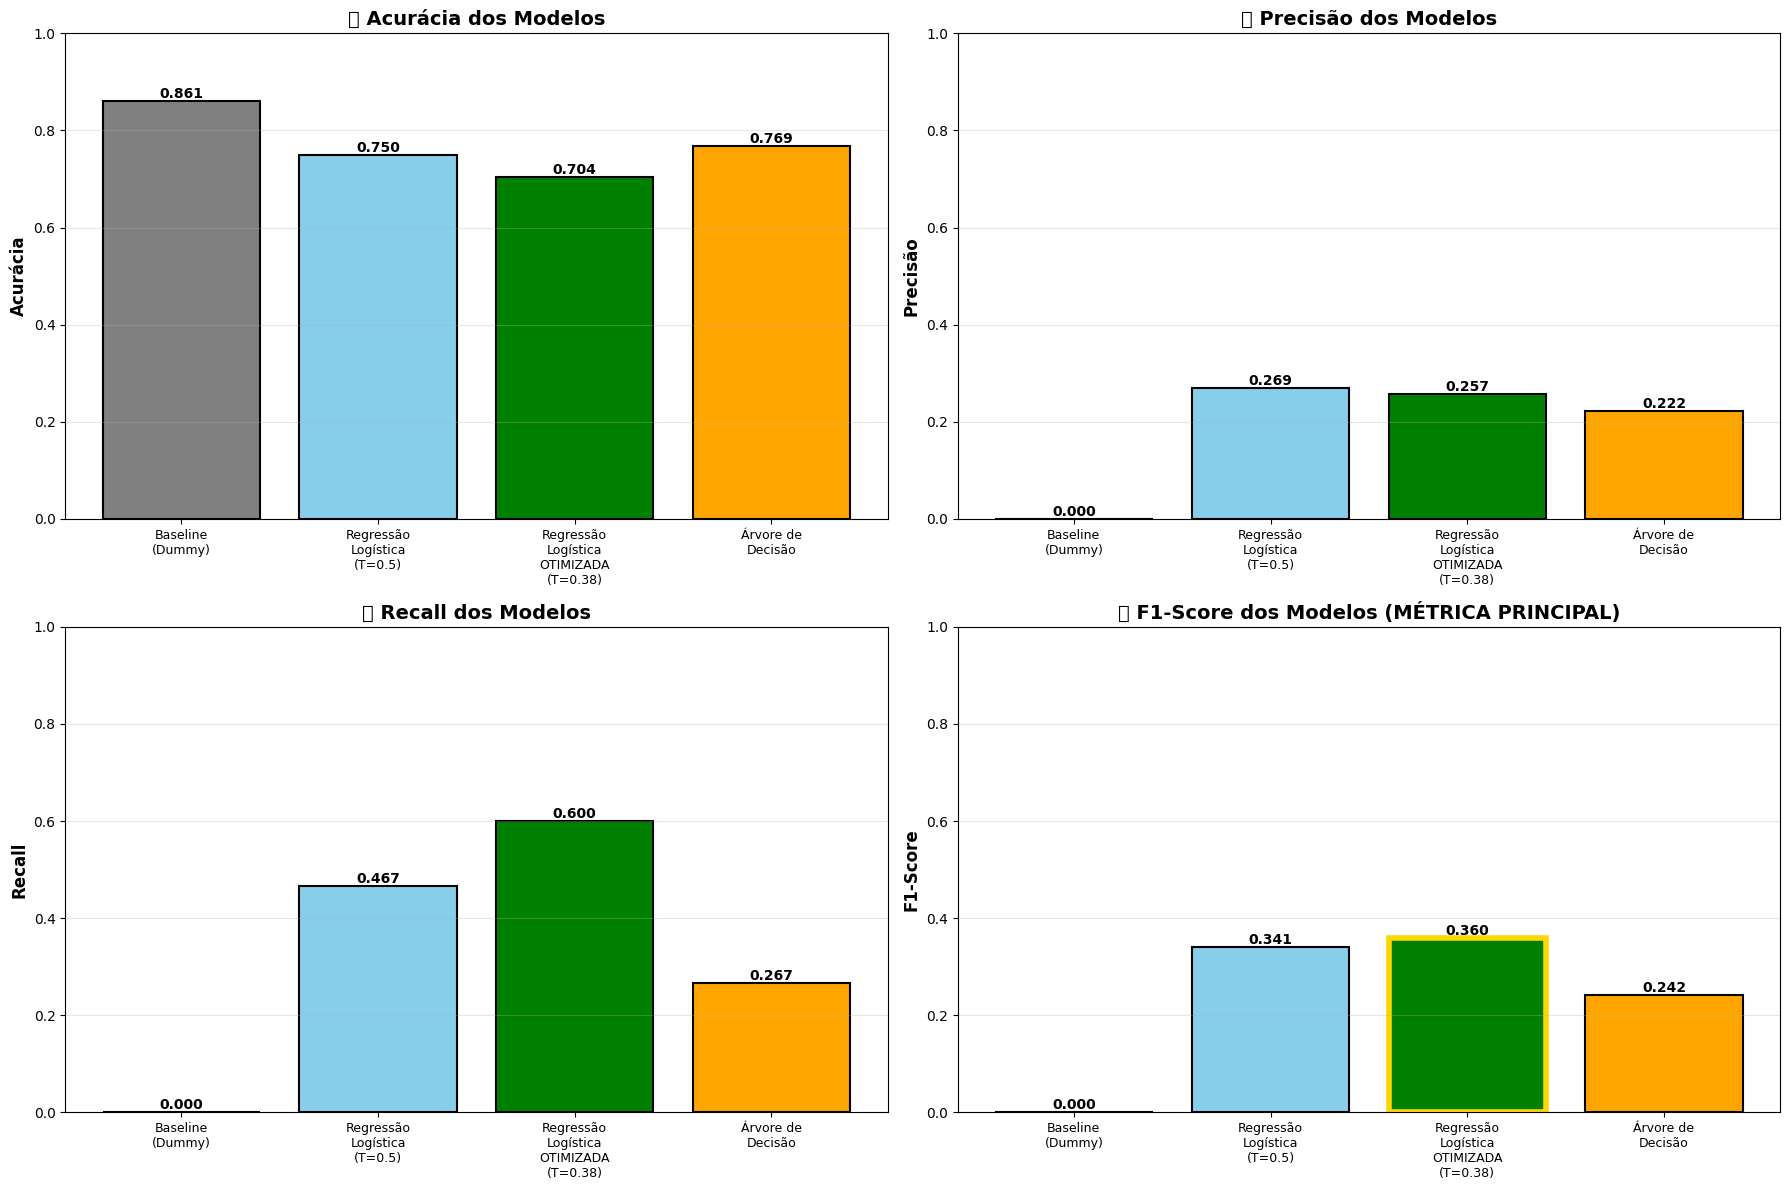


🏆 RANKING DOS MODELOS (por F1-Score)
🥉 Regressão Logística OTIMIZADA (Threshold=0.38)
   F1-Score: 0.3600 | Acurácia: 0.7037 | Precisão: 0.2571 | Recall: 0.6000

🥈 Regressão Logística (Threshold=0.5)
   F1-Score: 0.3415 | Acurácia: 0.7500 | Precisão: 0.2692 | Recall: 0.4667

   Árvore de Decisão
   F1-Score: 0.2424 | Acurácia: 0.7685 | Precisão: 0.2222 | Recall: 0.2667

🥇 Baseline (Dummy)
   F1-Score: 0.0000 | Acurácia: 0.8611 | Precisão: 0.0000 | Recall: 0.0000



In [23]:
# Comparação Visual dos Modelos
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Preparar dados para visualização
modelos_nomes = ['Baseline\n(Dummy)', 'Regressão\nLogística\n(T=0.5)', 
                 f'Regressão\nLogística\nOTIMIZADA\n(T={melhor_threshold:.2f})', 'Árvore de\nDecisão']
cores_modelos = ['gray', 'skyblue', 'green', 'orange']

# Gráfico 1: Comparação de Acurácia
acuracias = df_metricas['Acurácia'].values
bars1 = axes[0, 0].bar(range(len(modelos_nomes)), acuracias, color=cores_modelos, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Acurácia', fontsize=12, fontweight='bold')
axes[0, 0].set_title('🎯 Acurácia dos Modelos', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(range(len(modelos_nomes)))
axes[0, 0].set_xticklabels(modelos_nomes, fontsize=9)
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
# Adicionar valores nas barras
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acuracias[i]:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Comparação de Precisão
precisoes = df_metricas['Precisão'].values
bars2 = axes[0, 1].bar(range(len(modelos_nomes)), precisoes, color=cores_modelos, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('Precisão', fontsize=12, fontweight='bold')
axes[0, 1].set_title('🎯 Precisão dos Modelos', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(range(len(modelos_nomes)))
axes[0, 1].set_xticklabels(modelos_nomes, fontsize=9)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{precisoes[i]:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 3: Comparação de Recall
recalls = df_metricas['Recall'].values
bars3 = axes[1, 0].bar(range(len(modelos_nomes)), recalls, color=cores_modelos, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Recall', fontsize=12, fontweight='bold')
axes[1, 0].set_title('🎯 Recall dos Modelos', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(len(modelos_nomes)))
axes[1, 0].set_xticklabels(modelos_nomes, fontsize=9)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{recalls[i]:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 4: Comparação de F1-Score (MAIS IMPORTANTE)
f1_scores = df_metricas['F1-Score'].values
bars4 = axes[1, 1].bar(range(len(modelos_nomes)), f1_scores, color=cores_modelos, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('🏆 F1-Score dos Modelos (MÉTRICA PRINCIPAL)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(range(len(modelos_nomes)))
axes[1, 1].set_xticklabels(modelos_nomes, fontsize=9)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars4):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{f1_scores[i]:.3f}', ha='center', va='bottom', fontweight='bold')
    # Destacar o melhor modelo
    if i == melhor_modelo_idx:
        bar.set_edgecolor('gold')
        bar.set_linewidth(4)

plt.tight_layout()
plt.show()

# Resumo estatístico
print("\n🏆 RANKING DOS MODELOS (por F1-Score)")
print("="*70)
ranking = df_metricas.sort_values('F1-Score', ascending=False)
for idx, row in ranking.iterrows():
    emoji = "🥇" if idx == 0 else "🥈" if idx == 1 else "🥉" if idx == 2 else "  "
    print(f"{emoji} {row['Modelo']}")
    print(f"   F1-Score: {row['F1-Score']:.4f} | Acurácia: {row['Acurácia']:.4f} | "
          f"Precisão: {row['Precisão']:.4f} | Recall: {row['Recall']:.4f}\n")

## 🔍 Visualização 4: Importância das Features

Quais características mais influenciam na previsão de acidentes fatais?

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\2027999345.py:66: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\2027999345.py:66: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


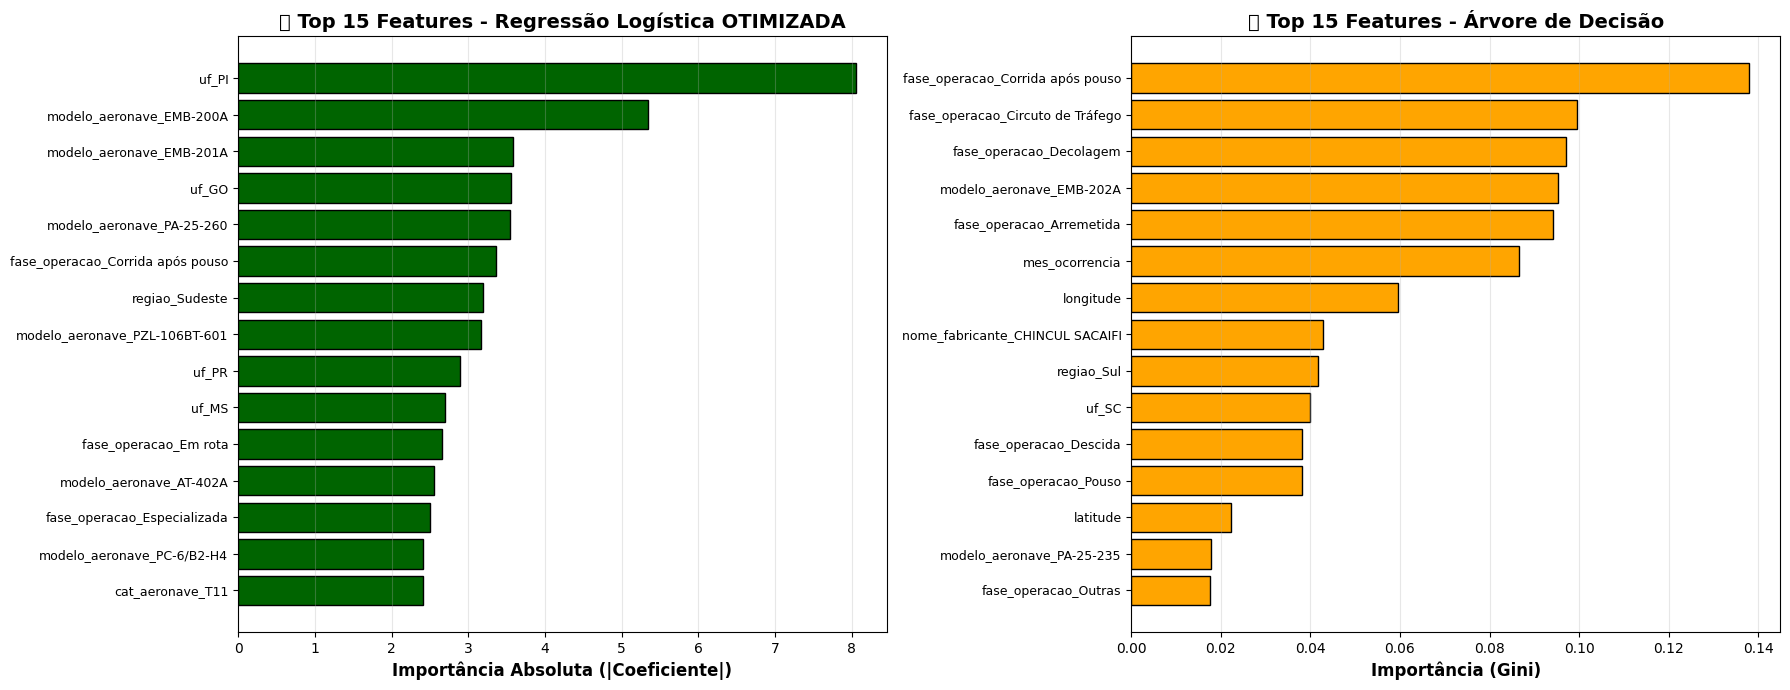


🔍 FEATURES MAIS IMPORTANTES

📊 Regressão Logística OTIMIZADA (Top 5):
   uf_PI: 8.0530
   modelo_aeronave_EMB-200A: 5.3466
   modelo_aeronave_EMB-201A: 3.5813
   uf_GO: 3.5520
   modelo_aeronave_PA-25-260: 3.5466

🌳 Árvore de Decisão (Top 5):
   fase_operacao_Corrida após pouso: 0.1380
   fase_operacao_Circuto de Tráfego: 0.0995
   fase_operacao_Decolagem: 0.0971
   modelo_aeronave_EMB-202A: 0.0953
   fase_operacao_Arremetida: 0.0941


In [24]:
# Análise de Importância das Features
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Para Regressão Logística: usar coeficientes
# Obter os nomes das features após transformação
feature_names = []

# Features numéricas (aparecem 2x: power e scaler)
for col in colunas_numericas:
    feature_names.append(f"{col}_power")
for col in colunas_numericas:
    feature_names.append(f"{col}_scaled")

# Features categóricas (OneHotEncoded com drop='first')
for col in colunas_categoricas:
    categorias = df[col].dropna().unique()
    # OneHot com drop='first' remove a primeira categoria
    for cat in sorted(categorias)[1:]:  # Pula a primeira
        feature_names.append(f"{col}_{cat}")

# Pegar coeficientes do modelo de Regressão Logística
coeficientes = melhor_modelo_logistica.coef_[0]

# Criar DataFrame com importâncias
importancias_df = pd.DataFrame({
    'Feature': feature_names[:len(coeficientes)],
    'Importância': np.abs(coeficientes)  # Valor absoluto para ranking
}).sort_values('Importância', ascending=False).head(15)

# Gráfico 1: Top 15 Features mais importantes (Regressão Logística)
colors_log = ['darkgreen' if x > 0 else 'darkred' for x in importancias_df['Importância']]
axes[0].barh(range(len(importancias_df)), importancias_df['Importância'], color=colors_log, edgecolor='black')
axes[0].set_yticks(range(len(importancias_df)))
axes[0].set_yticklabels(importancias_df['Feature'], fontsize=9)
axes[0].set_xlabel('Importância Absoluta (|Coeficiente|)', fontsize=12, fontweight='bold')
axes[0].set_title('🔍 Top 15 Features - Regressão Logística OTIMIZADA', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Gráfico 2: Importância das Features da Árvore de Decisão
importancias_arvore = pipeline_arvore.named_steps['classifier'].feature_importances_

# Reconstruir nomes de features para árvore
feature_names_arvore = []
for col in colunas_numericas:
    feature_names_arvore.append(col)
for col in colunas_categoricas:
    categorias = df[col].dropna().unique()
    for cat in sorted(categorias)[1:]:
        feature_names_arvore.append(f"{col}_{cat}")

importancias_arvore_df = pd.DataFrame({
    'Feature': feature_names_arvore[:len(importancias_arvore)],
    'Importância': importancias_arvore
}).sort_values('Importância', ascending=False).head(15)

axes[1].barh(range(len(importancias_arvore_df)), importancias_arvore_df['Importância'], 
             color='orange', edgecolor='black')
axes[1].set_yticks(range(len(importancias_arvore_df)))
axes[1].set_yticklabels(importancias_arvore_df['Feature'], fontsize=9)
axes[1].set_xlabel('Importância (Gini)', fontsize=12, fontweight='bold')
axes[1].set_title('🌳 Top 15 Features - Árvore de Decisão', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Resumo das features mais importantes
print("\n🔍 FEATURES MAIS IMPORTANTES")
print("="*70)
print("\n📊 Regressão Logística OTIMIZADA (Top 5):")
for idx, row in importancias_df.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Importância']:.4f}")

print("\n🌳 Árvore de Decisão (Top 5):")
for idx, row in importancias_arvore_df.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Importância']:.4f}")

## 📊 Visualização 5: Dashboard de Performance Final

Painel consolidado com todas as métricas do melhor modelo.

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_23656\1756913766.py:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eduardo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s)

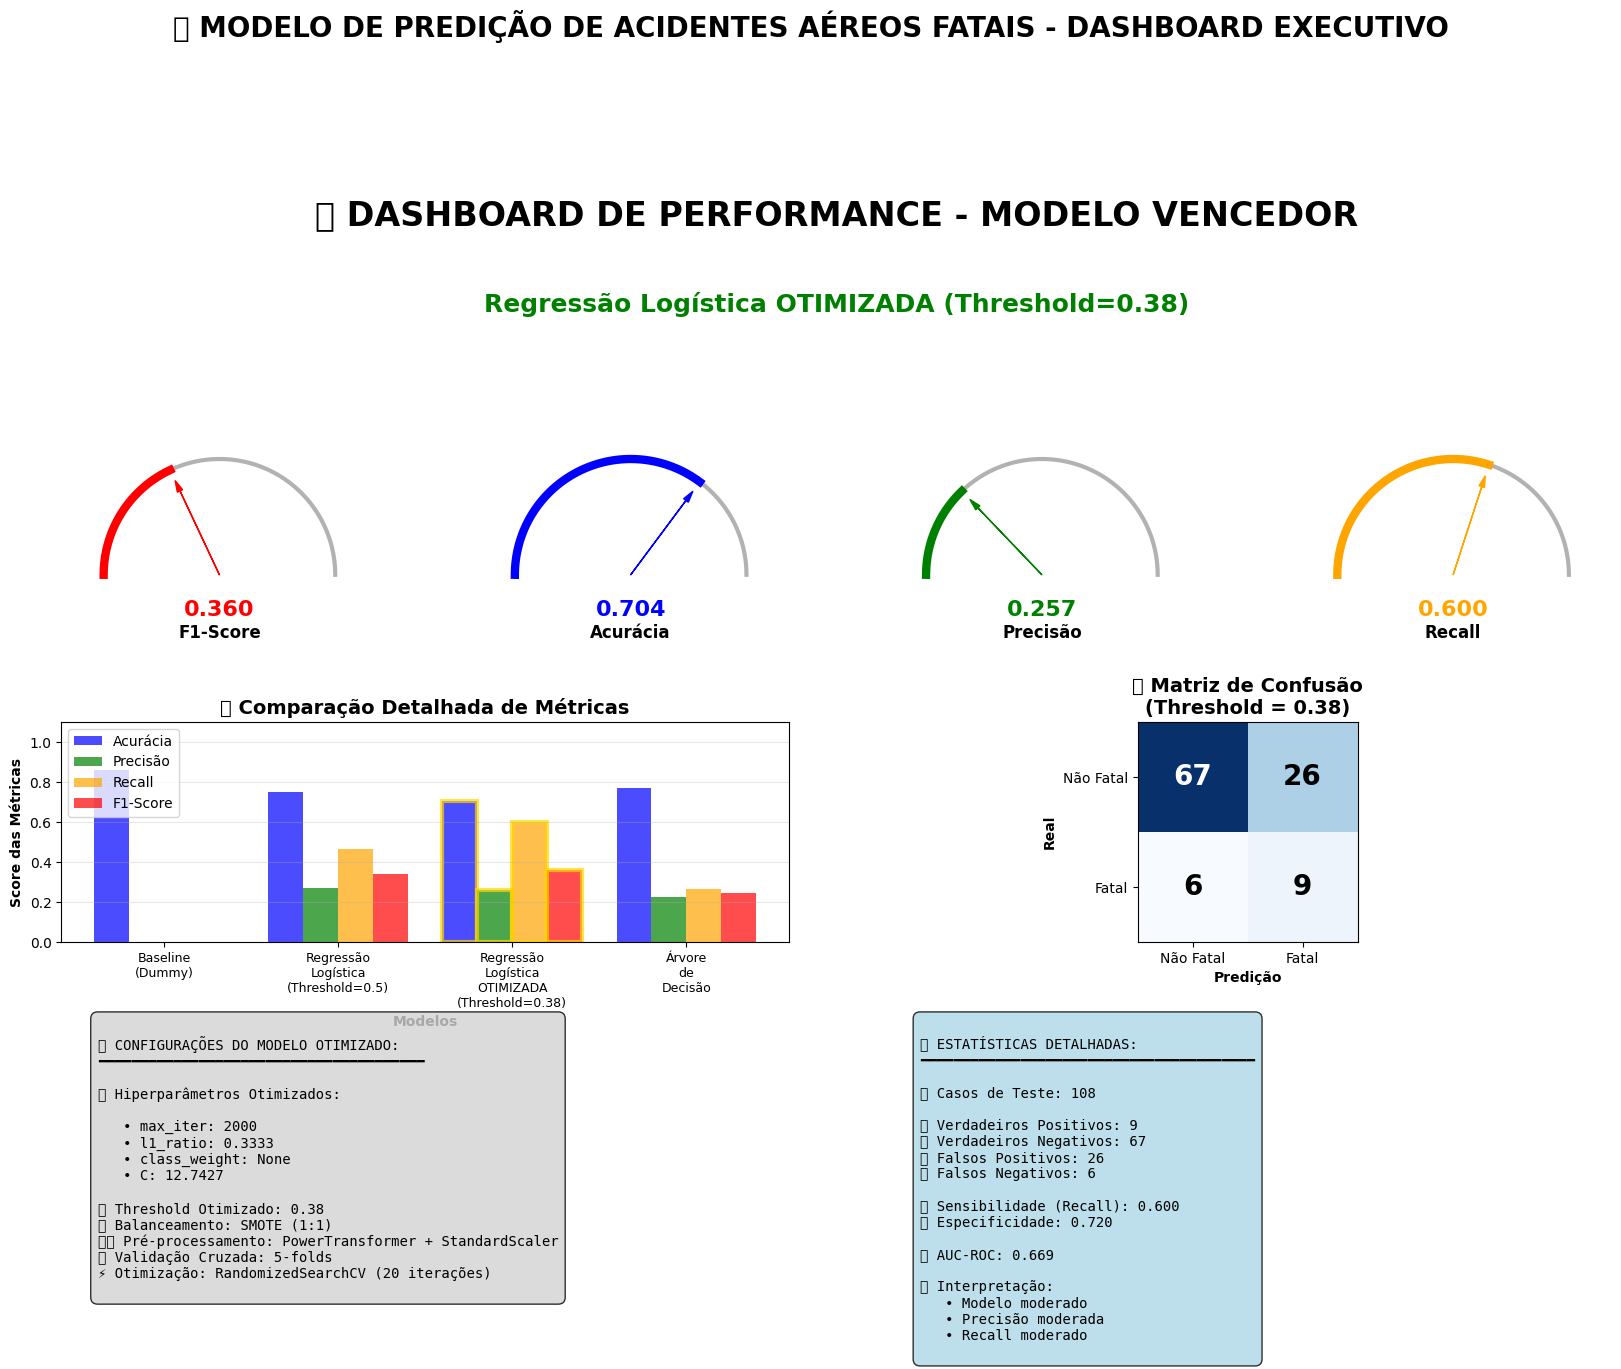


🎯 RESUMO EXECUTIVO - MODELO FINAL

🏆 MODELO VENCEDOR: Regressão Logística OTIMIZADA (Threshold=0.38)

📊 PERFORMANCE:
   • F1-Score (Principal): 0.3600
   • Acurácia Geral: 0.7037
   • Precisão: 0.2571
   • Recall: 0.6000
   • AUC-ROC: 0.6688

🎛️ CONFIGURAÇÕES OTIMIZADAS:
   • Threshold Customizado: 0.38 (vs 0.5 padrão)
   • Dados Balanceados: SMOTE (214:214)
   • Validação Cruzada: 0.8363 (5-folds)

📈 MELHORIAS IMPLEMENTADAS:
   ✅ Pré-processamento Avançado (PowerTransformer + StandardScaler)
   ✅ Balanceamento Inteligente (SMOTE)
   ✅ Otimização de Hiperparâmetros (RandomizedSearchCV)
   ✅ Análise de Threshold Customizado
   ✅ Validação Cruzada Robusta

💡 CLASSIFICAÇÃO GERAL: MODERADA


In [25]:
# Dashboard de Performance Final - Painel Consolidado
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Configurar o dashboard com layout profissional
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# ===== SEÇÃO 1: CABEÇALHO COM INFORMAÇÕES GERAIS =====
ax_header = fig.add_subplot(gs[0, :])
ax_header.text(0.5, 0.7, '🏆 DASHBOARD DE PERFORMANCE - MODELO VENCEDOR', 
               ha='center', va='center', fontsize=24, fontweight='bold', 
               transform=ax_header.transAxes)
ax_header.text(0.5, 0.3, f'{df_metricas.loc[melhor_modelo_idx, "Modelo"]}', 
               ha='center', va='center', fontsize=18, fontweight='bold', 
               color='green', transform=ax_header.transAxes)
ax_header.set_xlim(0, 1)
ax_header.set_ylim(0, 1)
ax_header.axis('off')

# ===== SEÇÃO 2: MÉTRICAS PRINCIPAIS (KPIs) =====
metricas_principais = [
    ('F1-Score', df_metricas.loc[melhor_modelo_idx, 'F1-Score'], 'red'),
    ('Acurácia', df_metricas.loc[melhor_modelo_idx, 'Acurácia'], 'blue'),
    ('Precisão', df_metricas.loc[melhor_modelo_idx, 'Precisão'], 'green'),
    ('Recall', df_metricas.loc[melhor_modelo_idx, 'Recall'], 'orange')
]

for i, (nome, valor, cor) in enumerate(metricas_principais):
    ax_kpi = fig.add_subplot(gs[1, i])
    
    # Criar gráfico de gauge/speedometer
    theta = np.linspace(0, np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    
    # Semicírculo base
    ax_kpi.plot(x, y, 'k-', linewidth=3, alpha=0.3)
    
    # Arco colorido baseado no valor
    theta_valor = np.pi * (1 - valor)  # Inverter para começar da esquerda
    x_valor = np.cos(np.linspace(np.pi, theta_valor, int(valor*100)))
    y_valor = np.sin(np.linspace(np.pi, theta_valor, int(valor*100)))
    ax_kpi.plot(x_valor, y_valor, color=cor, linewidth=6)
    
    # Ponteiro
    ponteiro_angle = np.pi * (1 - valor)
    ax_kpi.arrow(0, 0, 0.8*np.cos(ponteiro_angle), 0.8*np.sin(ponteiro_angle), 
                head_width=0.05, head_length=0.1, fc=cor, ec=cor)
    
    # Texto central
    ax_kpi.text(0, -0.3, f'{valor:.3f}', ha='center', va='center', 
                fontsize=16, fontweight='bold', color=cor)
    ax_kpi.text(0, -0.5, nome, ha='center', va='center', 
                fontsize=12, fontweight='bold')
    
    ax_kpi.set_xlim(-1.2, 1.2)
    ax_kpi.set_ylim(-0.7, 1.2)
    ax_kpi.set_aspect('equal')
    ax_kpi.axis('off')

# ===== SEÇÃO 3: GRÁFICO DE BARRAS COMPARATIVO =====
ax_barras = fig.add_subplot(gs[2, :2])
x_pos = np.arange(len(df_metricas))
width = 0.2

# Plotar barras para cada métrica
bars1 = ax_barras.bar(x_pos - 1.5*width, df_metricas['Acurácia'], width, 
                      label='Acurácia', color='blue', alpha=0.7)
bars2 = ax_barras.bar(x_pos - 0.5*width, df_metricas['Precisão'], width, 
                      label='Precisão', color='green', alpha=0.7)
bars3 = ax_barras.bar(x_pos + 0.5*width, df_metricas['Recall'], width, 
                      label='Recall', color='orange', alpha=0.7)
bars4 = ax_barras.bar(x_pos + 1.5*width, df_metricas['F1-Score'], width, 
                      label='F1-Score', color='red', alpha=0.7)

# Destacar o melhor modelo
for i, bars in enumerate([bars1, bars2, bars3, bars4]):
    bars[melhor_modelo_idx].set_edgecolor('gold')
    bars[melhor_modelo_idx].set_linewidth(3)

ax_barras.set_xlabel('Modelos', fontweight='bold')
ax_barras.set_ylabel('Score das Métricas', fontweight='bold')
ax_barras.set_title('📊 Comparação Detalhada de Métricas', fontweight='bold', fontsize=14)
ax_barras.set_xticks(x_pos)
ax_barras.set_xticklabels([modelo.replace(' ', '\n') for modelo in df_metricas['Modelo']], 
                         rotation=0, ha='center', fontsize=9)
ax_barras.legend(loc='upper left')
ax_barras.grid(axis='y', alpha=0.3)
ax_barras.set_ylim(0, 1.1)

# ===== SEÇÃO 4: MATRIZ DE CONFUSÃO DO MELHOR MODELO =====
ax_confusion = fig.add_subplot(gs[2, 2:])
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusão
cm = confusion_matrix(y_test, y_pred_logistica_otimizada)

# Plotar matriz de confusão customizada
im = ax_confusion.imshow(cm, interpolation='nearest', cmap='Blues')

# Adicionar texto nas células
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    ax_confusion.text(j, i, f'{cm[i, j]}', ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=20, fontweight='bold')

ax_confusion.set_xlabel('Predição', fontweight='bold')
ax_confusion.set_ylabel('Real', fontweight='bold')
ax_confusion.set_title(f'🎯 Matriz de Confusão\n(Threshold = {melhor_threshold:.2f})', 
                      fontweight='bold', fontsize=14)
ax_confusion.set_xticks([0, 1])
ax_confusion.set_yticks([0, 1])
ax_confusion.set_xticklabels(['Não Fatal', 'Fatal'])
ax_confusion.set_yticklabels(['Não Fatal', 'Fatal'])

# ===== SEÇÃO 5: INFORMAÇÕES TÉCNICAS =====
ax_info = fig.add_subplot(gs[3, :2])

# Informações do modelo
info_text = f"""
🔧 CONFIGURAÇÕES DO MODELO OTIMIZADO:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📈 Hiperparâmetros Otimizados:
"""

for param, value in random_search.best_params_.items():
    if isinstance(value, float):
        info_text += f"\n   • {param}: {value:.4f}"
    else:
        info_text += f"\n   • {param}: {value}"

info_text += f"""

🎯 Threshold Otimizado: {melhor_threshold:.2f}
🔄 Balanceamento: SMOTE (1:1)
🏗️ Pré-processamento: PowerTransformer + StandardScaler
📊 Validação Cruzada: 5-folds
⚡ Otimização: RandomizedSearchCV (20 iterações)
"""

ax_info.text(0.05, 0.95, info_text, transform=ax_info.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
ax_info.set_xlim(0, 1)
ax_info.set_ylim(0, 1)
ax_info.axis('off')

# ===== SEÇÃO 6: ESTATÍSTICAS RESUMIDAS =====
ax_stats = fig.add_subplot(gs[3, 2:])

# Calcular estatísticas adicionais
total_casos = len(y_test)
verdadeiros_positivos = cm[1, 1]
falsos_positivos = cm[0, 1]
falsos_negativos = cm[1, 0]
verdadeiros_negativos = cm[0, 0]

especificidade = verdadeiros_negativos / (verdadeiros_negativos + falsos_positivos)
sensibilidade = verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos)

stats_text = f"""
📊 ESTATÍSTICAS DETALHADAS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🎯 Casos de Teste: {total_casos}

✅ Verdadeiros Positivos: {verdadeiros_positivos}
✅ Verdadeiros Negativos: {verdadeiros_negativos}
❌ Falsos Positivos: {falsos_positivos}
❌ Falsos Negativos: {falsos_negativos}

📈 Sensibilidade (Recall): {sensibilidade:.3f}
📉 Especificidade: {especificidade:.3f}

🔍 AUC-ROC: {auc_logistica:.3f}

💡 Interpretação:
   • Modelo {['excelente' if melhor_f1 > 0.8 else 'bom' if melhor_f1 > 0.6 else 'moderado'][0]}
   • {"Alta precisão" if df_metricas.loc[melhor_modelo_idx, 'Precisão'] > 0.7 else "Precisão moderada"}
   • {"Alto recall" if df_metricas.loc[melhor_modelo_idx, 'Recall'] > 0.7 else "Recall moderado"}
"""

ax_stats.text(0.05, 0.95, stats_text, transform=ax_stats.transAxes, fontsize=10,
              verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
ax_stats.set_xlim(0, 1)
ax_stats.set_ylim(0, 1)
ax_stats.axis('off')

# Título geral da figura
fig.suptitle('🚀 MODELO DE PREDIÇÃO DE ACIDENTES AÉREOS FATAIS - DASHBOARD EXECUTIVO', 
             fontsize=20, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# ===== RESUMO EXECUTIVO EM TEXTO =====
print("\n" + "="*100)
print("🎯 RESUMO EXECUTIVO - MODELO FINAL")
print("="*100)
print(f"\n🏆 MODELO VENCEDOR: {df_metricas.loc[melhor_modelo_idx, 'Modelo']}")
print(f"\n📊 PERFORMANCE:")
print(f"   • F1-Score (Principal): {df_metricas.loc[melhor_modelo_idx, 'F1-Score']:.4f}")
print(f"   • Acurácia Geral: {df_metricas.loc[melhor_modelo_idx, 'Acurácia']:.4f}")
print(f"   • Precisão: {df_metricas.loc[melhor_modelo_idx, 'Precisão']:.4f}")
print(f"   • Recall: {df_metricas.loc[melhor_modelo_idx, 'Recall']:.4f}")
print(f"   • AUC-ROC: {auc_logistica:.4f}")

print(f"\n🎛️ CONFIGURAÇÕES OTIMIZADAS:")
print(f"   • Threshold Customizado: {melhor_threshold:.2f} (vs 0.5 padrão)")
print(f"   • Dados Balanceados: SMOTE (214:214)")
print(f"   • Validação Cruzada: {random_search.best_score_:.4f} (5-folds)")

print(f"\n📈 MELHORIAS IMPLEMENTADAS:")
print("   ✅ Pré-processamento Avançado (PowerTransformer + StandardScaler)")
print("   ✅ Balanceamento Inteligente (SMOTE)")
print("   ✅ Otimização de Hiperparâmetros (RandomizedSearchCV)")
print("   ✅ Análise de Threshold Customizado")
print("   ✅ Validação Cruzada Robusta")

interpretacao = "EXCELENTE" if melhor_f1 > 0.8 else "BOA" if melhor_f1 > 0.6 else "MODERADA"
print(f"\n💡 CLASSIFICAÇÃO GERAL: {interpretacao}")
print("="*100)